In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from time import time
from scipy.spatial.distance import euclidean
from sklearn.metrics import average_precision_score
from scipy.stats import multivariate_normal as multi_norm

/Users/tradergllc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/proc/reality-mining/txt/interim/bluetoothDevicesByWeek.txt', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [3]:
def convert_to_dict(df):
    data_dict = {}
    
    unique = list(df.iloc[:, 2].unique())
    
    date_list = [df.iloc[0, 1]]
    pid_date_list = [(df.iloc[0,0], df.iloc[0, 1])]
    
    data_dict[int(df.iloc[0,0])] = {}
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]] = np.zeros((len(unique),))
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]][unique.index(df.iloc[0, 2])] = 1
        
    for r in range(1, len(df.index)):
        pid = int(df.iloc[r, 0])
        if pid not in data_dict.keys():
            data_dict[pid] = {}        
        
        if (df.iloc[r, 0], df.iloc[r, 1]) in pid_date_list:
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1 #df.iloc[r, 3]
        else:
            date_list.append(df.iloc[r, 1])
            pid_date_list.append((df.iloc[r, 0], df.iloc[r, 1]))
            
            data_dict[pid][df.iloc[r, 1]] = np.zeros((len(unique),))
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1
                        
    return data_dict, unique

In [4]:
data_dict, unique = convert_to_dict(df)

In [5]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
#             print pid, date
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [6]:
x_train_full, y_train = dict_to_np_array(data_dict)
print x_train_full.shape, y_train.shape

(1841, 23275) (1841,)


In [7]:
x_train = x_train_full[:, x_train_full.sum(axis=0).argsort()[::-1][:72*72]].reshape((-1, 72,72,1))

### Train VAE

In [8]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = 72

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 8
epochs = 30

In [10]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 36, 36, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 18, 18, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 20736)        0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [11]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 20736)             186624    
_________________________________________________________________
reshape_1 (Reshape)          (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 36, 36, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 72, 72, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 72, 72, 1)         289       
Total params: 242,305
Trainable params: 242,305
Non-trainable params: 0
_________________________________________________________________


In [12]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [13]:
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
# plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 72, 72, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 8), (None, 8), (N 350880    
_________________________________________________________________
decoder (Model)              (None, 72, 72, 1)         242305    
Total params: 593,185
Trainable params: 593,185
Non-trainable params: 0
_________________________________________________________________


In [14]:
# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/30
1841/1841 [==============================] - 21s 11ms/step - loss: 384540.5836
Epoch 2/30
1841/1841 [==============================] - 20s 11ms/step - loss: 418.9479
Epoch 3/30
1841/1841 [==============================] - 24s 13ms/step - loss: 392.4479
Epoch 4/30
1841/1841 [==============================] - 23s 12ms/step - loss: 374.4141
Epoch 5/30
1841/1841 [==============================] - 19s 10ms/step - loss: 355.9413
Epoch 6/30
1841/1841 [==============================] - 20s 11ms/step - loss: 333.9805
Epoch 7/30
1841/1841 [==============================] - 22s 12ms/step - loss: 313.7095
Epoch 8/30
1841/1841 [==============================] - 19s 10ms/step - loss: 287.5296
Epoch 9/30
1841/1841 [==============================] - 19s 10ms/step - loss: 263.6065
Epoch 10/30
1841/1841 [==============================] - 19s 10ms/step - loss: 241.0252
Epoch 11/30
1841/1841 [==============================] - 19s 10ms/step - loss: 223.2908
Epoch 12/30
1841/1841 [===============

In [19]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs[2])

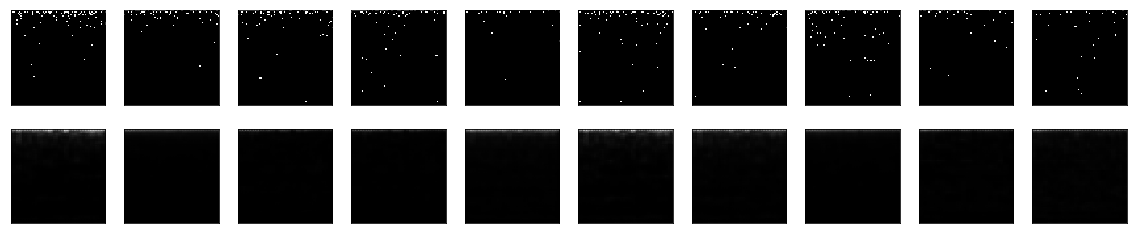

In [20]:
n = 10  # how many digits we will display
choice = np.random.choice(range(len(x_train)), n, replace=False)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[choice[i]].reshape((72,72)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[choice[i]].reshape((72,72)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

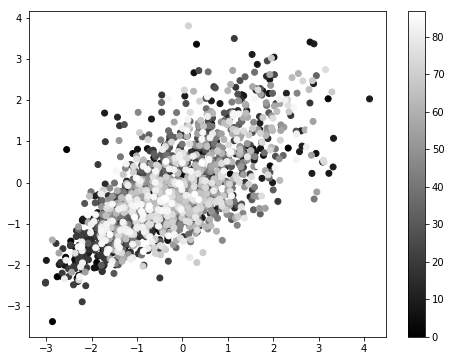

In [22]:
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)
x_test_encoded = np.array(x_test_encoded)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_train)
plt.colorbar()
plt.show()

In [23]:
mean = np.mean(x_test_encoded[0], axis=0)
print mean

std = np.std(x_test_encoded[0], axis=0)
print std

[-0.31016302 -0.26779744  0.65152144 -0.2474451  -0.20863464 -0.21952148
  0.35564047 -0.35203525]
[0.9878071  0.8910724  0.7449101  0.4884263  0.63556665 0.23473789
 0.17441435 0.38463432]


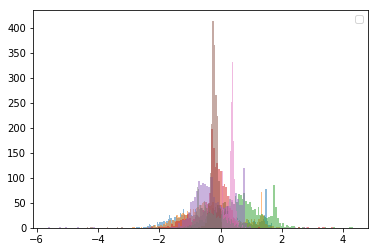

In [24]:
for i in range(len(std)):
    plt.hist(x_test_encoded[0, :, i], bins=100, alpha=0.5)

# plt.axvline(mean[0], color='green', linestyle='dashed', linewidth=1)
# plt.axvline(mean[1], color='red', linestyle='dashed', linewidth=1)

plt.legend()
plt.show()